In [70]:
# Core imports
import os
import json
import math
import warnings
from typing import List, Tuple

import numpy as np
import pandas as pd

# Visualization (safe to import; plots optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import joblib

# XGBoost
try:
	from xgboost import XGBClassifier
except Exception:
	import sys, subprocess
	print('Installing xgboost...')
	subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgboost'])
	from xgboost import XGBClassifier

# Imbalanced handling
try:
	from imblearn.combine import SMOTETomek, SMOTEENN
	from imblearn.pipeline import Pipeline as ImbPipeline
except Exception:
	import sys, subprocess
	print('Installing imbalanced-learn...')
	subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'imbalanced-learn'])
	from imblearn.combine import SMOTETomek, SMOTEENN
	from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')
np.random.seed(42)

print('Environment ready. Versions: pandas', pd.__version__)

Environment ready. Versions: pandas 2.2.3


In [71]:
# XGBoost with install fallback
try:
	from xgboost import XGBClassifier
except Exception:
	import sys, subprocess
	print('Installing xgboost...')
	subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgboost'])
	from xgboost import XGBClassifier
print('XGBoost ready')


XGBoost ready


In [72]:
# Data loading with robust path handling
DATA_PATH = os.path.normpath(os.path.join(os.path.dirname(os.getcwd()), 'dataset', 'data.csv'))
if not os.path.exists(DATA_PATH):
	# Fallback relative to this notebook location
	DATA_PATH = os.path.normpath(os.path.join('..', 'dataset', 'data.csv'))

assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"

# Read CSV (let pandas infer dtypes)
df = pd.read_csv(DATA_PATH)
print('Loaded shape:', df.shape)
df.head(3)

Loaded shape: (100000, 48)


,survey_code,age,gender,height,weight,bmi,bmi_estimated,bmi_scaled,bmi_corrected,waist_size,...,sunlight_exposure,meals_per_day,caffeine_intake,family_history,pet_owner,electrolyte_level,gene_marker_flag,environmental_risk_score,daily_supplement_dosage,target
0,1,56,Male,173.416872,56.886640,18.915925,18.915925,56.747776,18.989117,72.165130,...,High,5,Moderate,No,Yes,0,1.0,5.5,-2.275502,healthy
1,2,69,Female,163.207380,97.799859,36.716278,36.716278,110.148833,36.511417,85.598889,...,High,5,High,Yes,No,0,1.0,5.5,6.239340,healthy
2,3,46,Male,177.281966,80.687562,25.673050,25.673050,77.019151,25.587429,90.295030,...,High,4,Moderate,No,No,0,1.0,5.5,5.423737,healthy


In [73]:
# Basic schema snapshot
print('Columns:', len(df.columns))
print(sorted(df.columns.tolist())[:10], '...')
df.sample(5, random_state=42)

Columns: 48
['age', 'alcohol_consumption', 'blood_pressure', 'bmi', 'bmi_corrected', 'bmi_estimated', 'bmi_scaled', 'caffeine_intake', 'calorie_intake', 'cholesterol'] ...


,survey_code,age,gender,height,weight,bmi,bmi_estimated,bmi_scaled,bmi_corrected,waist_size,...,sunlight_exposure,meals_per_day,caffeine_intake,family_history,pet_owner,electrolyte_level,gene_marker_flag,environmental_risk_score,daily_supplement_dosage,target
75721,75722,67,Female,149.947350,74.182989,32.993375,32.993375,98.980124,33.095797,98.443866,...,Moderate,1,NaN,Yes,No,0,1.0,5.5,0.093056,healthy
80184,80185,62,Female,182.985926,71.861567,21.461561,21.461561,64.384683,21.270616,84.652929,...,Low,5,High,No,No,0,1.0,5.5,2.498928,diseased
19864,19865,44,Male,169.587159,63.328076,22.019647,22.019647,66.058942,21.827908,96.357967,...,Moderate,1,Moderate,Yes,Yes,0,1.0,5.5,5.504497,diseased
76699,76700,28,Male,174.371372,67.472986,22.191137,22.191137,66.573412,21.700315,72.028068,...,High,1,Moderate,Yes,Yes,0,1.0,5.5,-9.555787,diseased
92991,92992,38,Male,174.312119,87.895994,28.927701,28.927701,86.783103,28.797809,89.929984,...,Low,1,Moderate,Yes,No,0,NaN,5.5,6.062943,diseased


In [74]:
# Detailed info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   survey_code               100000 non-null  int64  
 1   age                       100000 non-null  int64  
 2   gender                    100000 non-null  object 
 3   height                    100000 non-null  float64
 4   weight                    100000 non-null  float64
 5   bmi                       100000 non-null  float64
 6   bmi_estimated             100000 non-null  float64
 7   bmi_scaled                100000 non-null  float64
 8   bmi_corrected             100000 non-null  float64
 9   waist_size                100000 non-null  float64
 10  blood_pressure            92331 non-null   float64
 11  heart_rate                85997 non-null   float64
 12  cholesterol               100000 non-null  float64
 13  glucose                   100000 non-null  fl

In [75]:
# Drop specific columns as requested (with typo handling)
requested_cols = [
	'bmi_etimated', 'bmi_corrected', 'bmi_scaled',
	'electrolyte_level', 'gene_maker_flag', 'environmental_risk_score'
]
# Map common typos to actual columns
alias_map = {
	'bmi_etimated': 'bmi_estimated',
	'gene_maker_flag': 'gene_marker_flag'
}
resolved_cols = [alias_map.get(c, c) for c in requested_cols]
existing_to_drop = [c for c in resolved_cols if c in df.columns]
missing_cols = [c for c in resolved_cols if c not in df.columns]

print('Requested to drop:', resolved_cols)
print('Dropping existing:', existing_to_drop)
if existing_to_drop:
	df = df.drop(columns=existing_to_drop)
print('Not found (ignored):', missing_cols)
print('Shape after explicit drops:', df.shape)


Requested to drop: ['bmi_estimated', 'bmi_corrected', 'bmi_scaled', 'electrolyte_level', 'gene_marker_flag', 'environmental_risk_score']
Dropping existing: ['bmi_estimated', 'bmi_corrected', 'bmi_scaled', 'electrolyte_level', 'gene_marker_flag', 'environmental_risk_score']
Not found (ignored): []
Shape after explicit drops: (100000, 42)


In [76]:
# Missing values overview
nulls = df.isnull().sum().sort_values(ascending=False)
missing_report = nulls[nulls > 0]
print(missing_report.head(20))
print('\nTotal missing cells:', int(nulls.sum()))

alcohol_consumption    42387
caffeine_intake        33261
exercise_type          24969
insulin                15836
heart_rate             14003
income                  8470
daily_steps             8329
blood_pressure          7669
dtype: int64

Total missing cells: 154924


In [77]:
# Do NOT drop columns with nulls; just report counts (handled by imputers later)
cols_with_nulls = df.columns[df.isnull().any()].tolist()
print('Columns containing nulls (will be imputed):', len(cols_with_nulls))
print('Sample with nulls:', cols_with_nulls[:10], '...' if len(cols_with_nulls) > 10 else '')
print('Shape before imputation (no drops here):', df.shape)


Columns containing nulls (will be imputed): 8
Sample with nulls: ['blood_pressure', 'heart_rate', 'insulin', 'daily_steps', 'alcohol_consumption', 'income', 'exercise_type', 'caffeine_intake'] 
Shape before imputation (no drops here): (100000, 42)


In [79]:
# Impute numeric nulls with column means
numeric_cols = df.select_dtypes(include=[np.number]).columns
before_nulls = int(df[numeric_cols].isnull().sum().sum())
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
after_nulls = int(df[numeric_cols].isnull().sum().sum())
print('Numeric nulls before:', before_nulls, '| after mean imputation:', after_nulls)


Numeric nulls before: 54307 | after mean imputation: 0


In [80]:
# Duplicate rows handling
dups = df.duplicated().sum()
print('Duplicate rows before drop:', dups)
if dups:
	df = df.drop_duplicates().reset_index(drop=True)
	print('Duplicates removed. New shape:', df.shape)
else:
	print('No duplicates found.')

Duplicate rows before drop: 0
No duplicates found.


In [81]:
# Target and feature schema
# Identify target column (from dataset description, 'target' is the label)
assert 'target' in df.columns, 'Expected target column named `target`'

# Map target to binary 1/0 if strings like 'healthy'/'diseased'
if df['target'].dtype == object:
	label_map = {k: i for i, k in enumerate(sorted(df['target'].unique()))}
	# Prefer 1 for diseased if present
	if set(df['target'].unique()) == set(['healthy', 'diseased']):
		label_map = {'healthy': 0, 'diseased': 1}
	y = df['target'].map(label_map).astype(int)
else:
	y = df['target'].astype(int)

# Drop obvious identifier/leakage columns if present
candidate_id_columns = ['survey_code']
existing_id_columns = [c for c in candidate_id_columns if c in df.columns]
X = df.drop(columns=['target'] + existing_id_columns)

# Split categorical vs numeric
categorical_columns = [c for c in X.columns if X[c].dtype == 'object']
numeric_columns = [c for c in X.columns if c not in categorical_columns]

print('Features:', X.shape[1], '| Numeric:', len(numeric_columns), '| Categorical:', len(categorical_columns))
print('Class balance:\n', y.value_counts(normalize=True).rename({0: 'class_0', 1: 'class_1'}))


Features: 40 | Numeric: 23 | Categorical: 17
Class balance:
 target
class_0    0.70097
class_1    0.29903
Name: proportion, dtype: float64


In [82]:
# Limit dataset to 20,000 rows using stratified sampling on the target
TARGET_N = 20000
if len(y) > TARGET_N:
	X, _, y, _ = train_test_split(
		X, y,
		test_size=len(y) - TARGET_N,
		random_state=42,
		stratify=y
	)
print('Using rows:', len(y))


Using rows: 20000


In [83]:
# Configure resampling for class imbalance
sampler_name = 'SMOTETomek'  # options: 'SMOTETomek', 'SMOTEENN'
if sampler_name == 'SMOTETomek':
	sampler = SMOTETomek(random_state=42)
elif sampler_name == 'SMOTEENN':
	sampler = SMOTEENN(random_state=42)
else:
	raise ValueError('Unsupported sampler_name')
print('Using sampler:', sampler_name)


Using sampler: SMOTETomek


In [84]:
# Train/validation/test split with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
	X, y, test_size=0.3, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
	X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print('Train:', X_train.shape, 'Valid:', X_valid.shape, 'Test:', X_test.shape)


Train: (14000, 40) Valid: (3000, 40) Test: (3000, 40)


In [85]:
# Simple preprocessing pipeline (dense output; numeric mean imputation)
numeric_transformer = Pipeline(steps=[
	('imputer', SimpleImputer(strategy='mean')),
	('scaler', StandardScaler())
])

# Build OneHotEncoder robustly across sklearn versions
try:
	encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
	# For older sklearn where sparse_output is unavailable
	encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
	('imputer', SimpleImputer(strategy='most_frequent')),
	('encoder', encoder)
])

preprocessor = ColumnTransformer(
	transformers=[
		('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
		('cat', categorical_transformer, make_column_selector(dtype_include=object))
	],
	sparse_threshold=0.0
)

print('Preprocessor ready (dense + mean impute).')


Preprocessor ready (dense + mean impute).


In [87]:
# Model selection with randomized hyperparameter search (ROC AUC)
FAST_MODE = True
cv = StratifiedKFold(n_splits=(3 if FAST_MODE else 5), shuffle=True, random_state=42)
common_n_iter = (8 if FAST_MODE else 25)

# Helper to build XGBClassifier robustly across versions
def make_xgb_classifier():
	try:
		return XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', tree_method='hist')
	except TypeError:
		return XGBClassifier(random_state=42, tree_method='hist')

search_spaces = {
	'log_reg': {
		'pipeline': ImbPipeline(steps=[('prep', preprocessor), ('sampler', sampler), ('clf', LogisticRegression(max_iter=1000))]),
		'params': {
			'clf__C': np.logspace(-3, 2, (8 if FAST_MODE else 20)),
			'clf__solver': ['liblinear', 'lbfgs'],
		}
	},
	'rf': {
		'pipeline': ImbPipeline(steps=[('prep', preprocessor), ('sampler', sampler), ('clf', RandomForestClassifier(random_state=42))]),
		'params': {
			'clf__n_estimators': (np.arange(100, 401, 100) if FAST_MODE else np.arange(200, 801, 100)),
			'clf__max_depth': [None] + list(np.arange(4, 13, 2) if FAST_MODE else np.arange(4, 21, 2)),
			'clf__min_samples_split': [2, 5, 10],
			'clf__min_samples_leaf': [1, 2, 4],
			'clf__max_features': ['sqrt', 'log2', None]
		}
	},
	'gbc': {
		'pipeline': ImbPipeline(steps=[('prep', preprocessor), ('sampler', sampler), ('clf', GradientBoostingClassifier(random_state=42))]),
		'params': {
			'clf__n_estimators': (np.arange(100, 301, 100) if FAST_MODE else np.arange(100, 601, 100)),
			'clf__learning_rate': (np.logspace(-2, -0.3, 6) if FAST_MODE else np.logspace(-2.5, 0, 20)),
			'clf__max_depth': (np.arange(2, 4) if FAST_MODE else np.arange(2, 5)),
			'clf__subsample': [0.8, 1.0] if FAST_MODE else [0.6, 0.8, 1.0]
		}
	}
}

# Optionally include XGBoost (can be heavy)
if not FAST_MODE:
	search_spaces['xgb'] = {
		'pipeline': ImbPipeline(steps=[('prep', preprocessor), ('sampler', sampler), ('clf', make_xgb_classifier())]),
		'params': {
			'clf__n_estimators': np.arange(200, 801, 150),
			'clf__max_depth': np.arange(3, 9),
			'clf__learning_rate': np.logspace(-2.5, -0.3, 12),
			'clf__subsample': [0.6, 0.8, 1.0],
			'clf__colsample_bytree': [0.6, 0.8, 1.0],
		}
	}

search_results = {}
best_search = None
best_name = None
best_score = -np.inf

for name, cfg in search_spaces.items():
	print(f'Running search for {name}...')
	random_search = RandomizedSearchCV(
		estimator=cfg['pipeline'],
		param_distributions=cfg['params'],
		n_iter=common_n_iter,
		scoring='roc_auc',
		cv=cv,
		n_jobs=-1,
		verbose=0,
		refit=True,
		random_state=42
	)
	random_search.fit(X_train, y_train)
	search_results[name] = {
		'best_score': random_search.best_score_,
		'best_params': random_search.best_params_,
		'best_estimator': random_search.best_estimator_
	}
	print(name, 'best ROC AUC (cv):', round(random_search.best_score_, 4))
	if random_search.best_score_ > best_score:
		best_score = random_search.best_score_
		best_search = random_search
		best_name = name

print('\nBest model by randomized CV:', best_name, 'ROC AUC:', round(best_score, 4))
	


Running search for log_reg...
log_reg best ROC AUC (cv): 0.4983
Running search for rf...
rf best ROC AUC (cv): 0.4992
Running search for gbc...
gbc best ROC AUC (cv): 0.5094

Best model by randomized CV: gbc ROC AUC: 0.5094


Test ROC AUC: 0.4899
Test PR AUC: 0.2937

Classification report:
               precision    recall  f1-score   support

           0      0.698     0.944     0.803      2103
           1      0.240     0.041     0.070       897

    accuracy                          0.674      3000
   macro avg      0.469     0.493     0.436      3000
weighted avg      0.561     0.674     0.584      3000



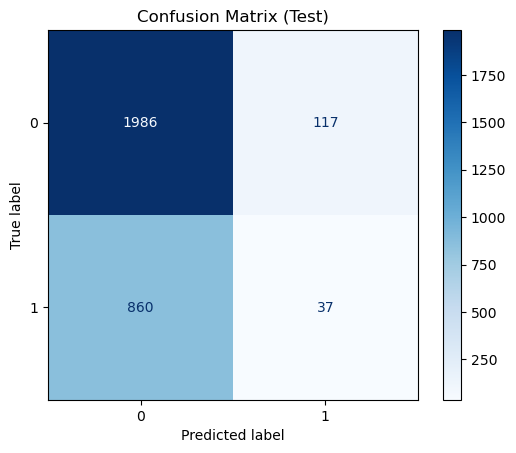

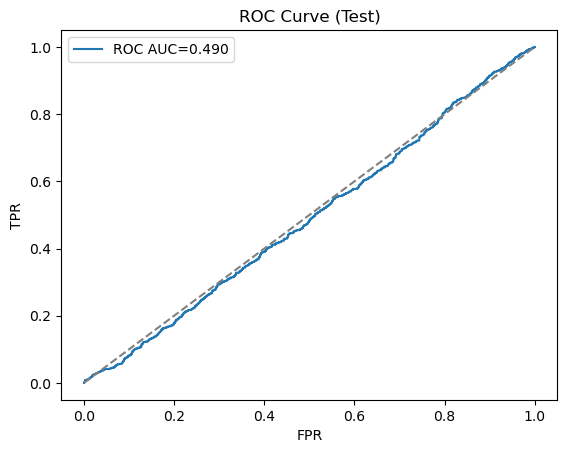

In [88]:
# Fit best on train+valid, evaluate on test
best_pipeline = best_search.best_estimator_
best_pipeline.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

proba_test = best_pipeline.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

print('Test ROC AUC:', round(roc_auc_score(y_test, proba_test), 4))
print('Test PR AUC:', round(average_precision_score(y_test, proba_test), 4))
print('\nClassification report:\n', classification_report(y_test, pred_test, digits=3))

cm = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.show()

fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc_score(y_test, proba_test):.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve (Test)'); plt.legend(); plt.show()


In [89]:
# Persist best model
ARTIFACT_DIR = os.path.join('..', 'artifacts')
os.makedirs(ARTIFACT_DIR, exist_ok=True)
MODEL_PATH = os.path.join(ARTIFACT_DIR, f'best_pipeline_{best_name}.joblib')
joblib.dump(best_pipeline, MODEL_PATH)
print('Saved:', MODEL_PATH)

# Report best params
try:
	print('Best selection:', best_name)
	print('Best CV ROC AUC:', round(best_score, 4))
	print('Best params:', json.dumps(best_search.best_params_, indent=2, default=str))
except Exception as e:
	print('Could not print best search details:', e)


Saved: ..\artifacts\best_pipeline_gbc.joblib
Best selection: gbc
Best CV ROC AUC: 0.5094
Best params: {
  "clf__subsample": 0.8,
  "clf__n_estimators": "200",
  "clf__max_depth": "2",
  "clf__learning_rate": 0.5011872336272722
}


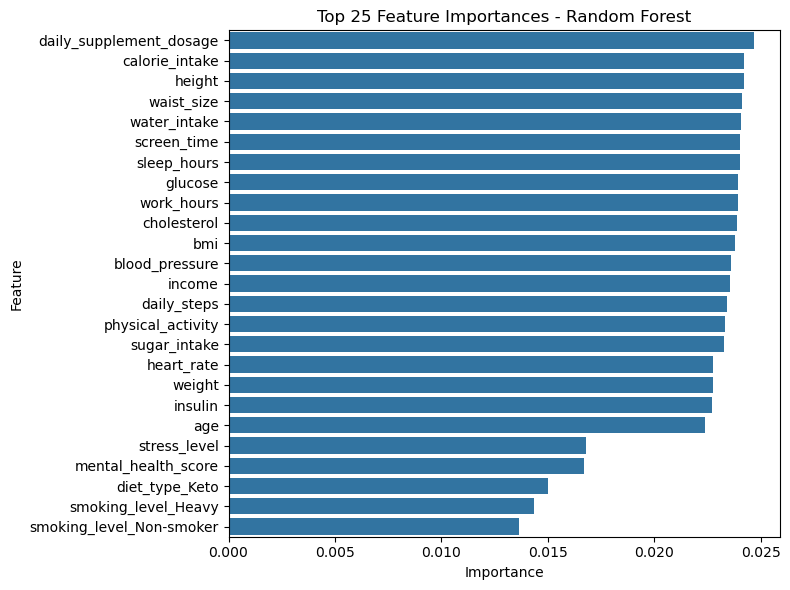

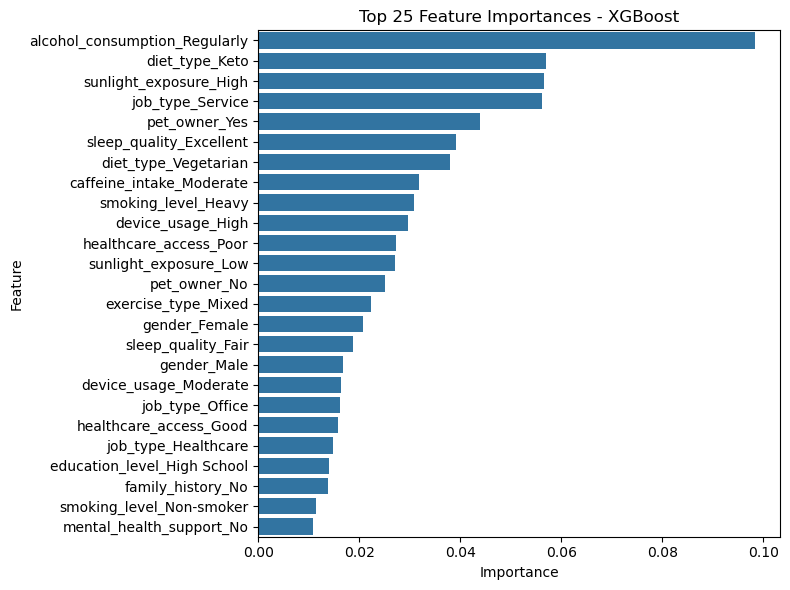

In [90]:
# Feature importance plots for Random Forest and XGBoost
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier

importances_to_plot = []

# Helper to get output feature names from preprocessor
def get_output_feature_names(preprocessor: ColumnTransformer) -> List[str]:
	feature_names = []
	for name, trans, cols in preprocessor.transformers_:
		if name == 'remainder':
			continue
		if hasattr(trans, 'named_steps') and 'encoder' in trans.named_steps:
			encoder = trans.named_steps['encoder']
			enc_feature_names = encoder.get_feature_names_out(cols).tolist()
			feature_names.extend(enc_feature_names)
		else:
			feature_names.extend(cols)
	return feature_names

# Define sampler
sampler = SMOTETomek(random_state=42)

# Build dedicated RF pipeline and fit on train+valid
rf_pipe = ImbPipeline(steps=[('prep', preprocessor), ('sampler', sampler), ('clf', RandomForestClassifier(random_state=42))])
rf_pipe.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

rf_clf = rf_pipe.named_steps['clf']
rf_feat_names = get_output_feature_names(rf_pipe.named_steps['prep'])
rf_importances = pd.Series(rf_clf.feature_importances_, index=rf_feat_names).sort_values(ascending=False).head(25)
importances_to_plot.append(('Random Forest', rf_importances))

# Build dedicated XGB pipeline and fit on train+valid
try:
	xgb_pipe = ImbPipeline(steps=[('prep', preprocessor), ('sampler', sampler), ('clf', XGBClassifier(
		random_state=42, use_label_encoder=False, eval_metric='logloss', tree_method='hist'
	))])
	xgb_pipe.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
	xgb_clf = xgb_pipe.named_steps['clf']
	xgb_feat_names = get_output_feature_names(xgb_pipe.named_steps['prep'])
	xgb_importances = pd.Series(xgb_clf.feature_importances_, index=xgb_feat_names).sort_values(ascending=False).head(25)
	importances_to_plot.append(('XGBoost', xgb_importances))
except Exception as e:
	print('XGBoost importance skipped:', e)

# Plot
for title, series in importances_to_plot:
	plt.figure(figsize=(8, 6))
	sns.barplot(x=series.values, y=series.index, orient='h')
	plt.title(f'Top 25 Feature Importances - {title}')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.tight_layout()
	plt.show()
